1DimToy will generate 1dim sipm responses to a prandomly generated hit on a 1d EL line. Then 1DimToy will train a neural network to learn the position of the hit, x, from the sipm response to the hit. 

In [1]:
from __future__ import print_function
%matplotlib inline
import pylab
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn import metrics
import random
import tables
import numpy as np
import tensorflow as tf
from sipm_param import *

NSIPM = 24    
NUM_ELPT = 1  # num points simulated in EL in same 'evt' 

sipm_pitch = 4.0  
sipm_edge_width = 2.0 # width of edge of dice board in mm
ze = 10.0             # distance between SiPM plane and EL gap
grid_space = 2.0      # grid spacing in mm
n_tbins = 2           # number of time bins collected as electron crosses EL

nevts = 9500 # num events for each num EL pt
train_size = 9000
cv_size = 500

max_xy = (NSIPM-1)*sipm_pitch + 2*sipm_edge_width # maximum x and y value (80 mm)
max_p = max_xy /grid_space                        # number of points per line (40)

sipm_res = np.zeros((nevts,NSIPM),dtype=np.float32)    #SiPM responses
x = np.empty((NUM_ELPT,nevts),dtype = np.float32)      #xcoord for evt

#create ndarray containing SiPM positions
sipm_pos= np.array([sipm_edge_width + i*sipm_pitch for i in range(NSIPM)])

print(max_xy)

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


96.0


Generate random EL hit for nevts:

In [2]:
for pt in range(NUM_ELPT): 
    for i in range(nevts): x[pt,i] = np.random.uniform(max_xy)

Genereate SiPM responses to these hits: 

In [3]:
def generate_SiPM_responses(NUM_ELPT,x,sipm_res):
    
    # for each EL point
    for pt in range(NUM_ELPT):    
        evt = 0
        
        # for each event
        for xi in x[pt]:     
            r = abs(sipm_pos - xi)
            # add sipm response to this EL point to sipm response to this event
            sipm_res[evt] = sipm_res[evt] + (sipm_par(0,r) + sipm_par(1,r)) # function in sipm_param.py 
            evt += 1

    sipm_res /= 2 # take mean of two time bins
    #Normalize for the DNN
    #mean = np.mean(sipm_res)
    mean = 0
    std = np.std(sipm_res)
    return (sipm_res - mean)/std
    
sipm_res = generate_SiPM_responses(NUM_ELPT,x,sipm_res)

Here is a plot of an EL hit and it's corresponding SiPM response. NOTE: the y coordinates for the EL hits are meaningless! 

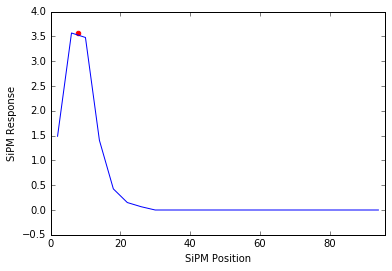

In [4]:
# dim1plot is a plot function that will also be useful later:
# it will plot with any number of el hits and can also plot 
# neural network output if given (predictions)
def dim1plot(lbl, data, predictions=None):
    # will only plot input data if cv_predidctions == None
    
    exevt = np.random.randint(lbl.shape[0])
    if   NUM_ELPT == 1: colors = ['r']
    elif NUM_ELPT == 2: colors = ['r','g']
    elif NUM_ELPT == 3: colors = ['r','g','b']
    
    # plot an event (el hit and sipm response)
    plt.scatter(lbl[exevt], np.array([np.max(data[exevt])]*NUM_ELPT), color=colors)
    plot = plt.plot(sipm_pos,data[exevt])
    pylab.xlim([0,max_xy])

    # plot network prediction:
    if type(predictions) != type(None):
        plt.scatter(predictions[exevt], 
                    np.array([np.max(data[exevt])]*NUM_ELPT)*.95, color=colors)

    plt.xlabel('SiPM Position')
    plt.ylabel('SiPM Response')
    plt.show()
    
dim1plot(x.T, sipm_res)

Organize and normalize data for training

In [5]:
# create training and cv data/labels. Note here they do not have to be preshuffled.
data_train = sipm_res[0:train_size]
lbl_train = (x.T[0:train_size]  - max_xy/2)/max_xy
data_cv = sipm_res[train_size:(train_size + cv_size)]
lbl_cv = (x.T[train_size:(train_size + cv_size)] - max_xy/2)/max_xy

Train with an out of the box linear regression (not TF):

In [6]:
from sklearn.linear_model import LinearRegression
def LinearReg(data_train,lbl_train,data_cv,lbl_cv,train_size):
    linreg = LinearRegression()
    linreg_model = linreg.fit(data_train, lbl_train[:train_size])
    print('----training now----')
    print('LinReg Score: %f' %linreg_model.score(data_cv,lbl_cv))

LinearReg(data_train,lbl_train[:,0],data_cv,lbl_cv[:,0],train_size)

----training now----
LinReg Score: 0.999255


Now with TF, set up input, lbls:

Make a single layer network (linear regression with stochastic grad descent):

In [19]:
# setup architecture
batchsize = 64

# for convenience define a pair of functions to set up weight variables and bias variables
def weight_variable(shape):
    in_neurons = 1
    for ii in shape[:-1]: in_neurons *= ii
    out_neurons = shape[-1]
    init_rng = np.sqrt(3.0 / (in_neurons + out_neurons))    # change 3.0 to 6.0 to use with random_uniform
    #initial = tf.random_uniform(shape,minval=-init_rng,maxval=init_rng)
    initial = tf.truncated_normal(shape, stddev=init_rng)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.01, shape=shape)
    return tf.Variable(initial)

# set up the graph
def setup_linreg_graph():
    LinReg = tf.Graph()
    with LinReg.as_default():

        trainx  = tf.placeholder(tf.float32, [batchsize, NSIPM])    # SiPM response input for training
        trainy_ = tf.placeholder(tf.float32, [batchsize, NUM_ELPT]) # training labels (xcoord of EL HIT)

        W = weight_variable([NSIPM,NUM_ELPT])
        b = bias_variable([NUM_ELPT])

        train_yout = tf.matmul(trainx,W) + b  # predicted output for training data


        loss = tf.nn.l2_loss(train_yout - trainy_)
        optimizer = tf.train.GradientDescentOptimizer(0.0001).minimize(loss)

        #train_acc = 1- np.abs(train_yout - trainy_)

        # for checking cross validation accuracy
        cvx     = tf.constant(data_cv)
        cvy_    = tf.constant(lbl_cv)  
        cv_yout = tf.matmul(cvx,   W) + b
        #cv_acc  = 1 - np.abs(cv_yout - cvy_)
    return LinReg,trainx,trainy_,train_yout,loss,optimizer,cv_yout


Really quick define an accuracy function:

In [8]:
# note accuracy can be negative
def accuracy(pred,lbls): 
    return metrics.r2_score(lbls, pred)

# error in average distance of a prediction point for its target
def error(pred,lbls):
    E=0.0
    for pt in range(NUM_ELPT):
        E = E + np.sqrt(
            np.sum(((lbls[:,pt] - pred[:,pt])*80)**2)/lbls.shape[0])
    return E/NUM_ELPT

Now run it:

In [10]:
def runTF(graph, numsteps, batchsize, data_train, lbl_train, lbl_cv, multidim=False):
    with tf.Session(graph=graph) as session:
        tf.initialize_all_variables().run()
        print("---Initialized---")

        for step in range(numsteps):
            # compute offset: //change this at some point
            offset = (step * batchsize) % (lbl_train.shape[0] - batchsize)

            # feed batch for training
            batch_data = data_train[offset:(offset + batchsize), :]
            batch_labels = lbl_train[offset:(offset + batchsize), :]
            feed_dict = {trainx : batch_data, trainy_ : batch_labels}   # where to find batch data/lbls
            _, l, predictions = session.run([optimizer, loss, train_yout], feed_dict=feed_dict)

            # compute error every 5k iterations
            if step % 50000 == 0: 
                print('---Checking new accuracy---')
                print('loss: '+ str(l))
                if multidim:
                    print('training error: ' + str(error(predictions, batch_labels)))
                    cv_predictions = cv_yout.eval()
                    print('cv error      : ' + str(error(cv_predictions, lbl_cv)))
                else:      
                    print('training accuracy: ' + str(accuracy(predictions, batch_labels)))
                    cv_predictions = cv_yout.eval()
                    print('cv accuracy      : ' + str(accuracy(cv_predictions, lbl_cv)))
        return cv_predictions
numsteps = 100001


LinReg,trainx,trainy_,train_yout,loss,optimizer,cv_yout = setup_linreg_graph()
cv_predictions = runTF(LinReg, numsteps, batchsize, data_train, lbl_train, lbl_cv)

# note accuracy can be negative here

---Initialized---
---Checking new accuracy---
loss: 89.8189
training accuracy: -33.9397967355
cv accuracy      : -32.8414014086
---Checking new accuracy---
loss: 0.00297427
training accuracy: 0.998907941216
cv accuracy      : 0.999290358911
---Checking new accuracy---
loss: 0.000432591
training accuracy: 0.99978733976
cv accuracy      : 0.999295595981


Here is a little plot function that compares neural network estimated output with labels and also Sipm response input.
Remember: the y coordinates of scatter plot data points are meaningless. 

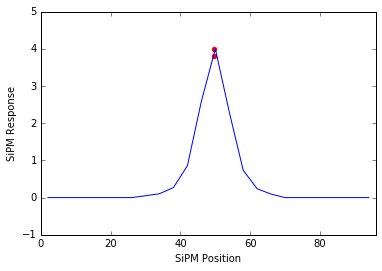

In [11]:
dim1plot(lbl_cv*max_xy + max_xy/2, data_cv, cv_predictions*max_xy + max_xy/2)

In [14]:
# modify dependent inputs
NUM_ELPT = 2
x = np.empty((NUM_ELPT,nevts),dtype=np.float32)
x[0] = np.random.uniform(0,max_xy/2,nevts)       # ***** Set x = np.random.uniform(0,max_xy,(NUM_ELPT,nevts))
x[1] = np.random.uniform(max_xy/2,max_xy,nevts)  # ***** and all the networks will fail! 


#This works, but not as well as above ^
#temp = np.random.uniform(0,max_xy,(NUM_ELPT,nevts))
#for i in range(nevts): 
#    if temp[0,i] < temp[1,i]:
#        x[:,i] = temp[:,i]
#    else:
#        x[0,i] = temp[1,i]
#        x[1,i] = temp[0,i]

#x = np.random.uniform(0,max_xy,(NUM_ELPT,nevts)) # ***** This will not work at all
    
    

sipm_res = np.zeros((nevts,NSIPM),dtype=np.float32)
sipm_res = generate_SiPM_responses(NUM_ELPT,x,sipm_res)

Here is a plot of our 2 El hit data

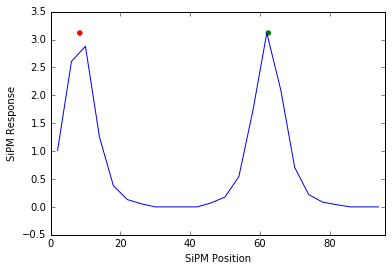

In [15]:
# plot again
dim1plot(x.T,sipm_res)

Set up the new data

In [16]:
# set up training dataset and cv dataset again
data_train = sipm_res[0:train_size]
lbl_train = (x.T[0:train_size]  - max_xy/2)/max_xy
data_cv = sipm_res[train_size:(train_size + cv_size)]
lbl_cv = (x.T[train_size:(train_size + cv_size)] - max_xy/2)/max_xy

print(data_train.shape)
print(lbl_train.shape)
print('=====')
print(data_cv.shape)
print(lbl_cv.shape)

(9000, 24)
(9000, 2)
=====
(500, 24)
(500, 2)


In [17]:
LinearReg(data_train,lbl_train,data_cv,lbl_cv,train_size)

----training now----
LinReg Score: 0.997596


Now try with tf lin regressor

In [20]:
batchsize = 500
LinReg,trainx,trainy_,train_yout,loss,optimizer,cv_yout = setup_linreg_graph()      # recreate the tf graph
cv_predictions = runTF(LinReg, numsteps, batchsize, data_train, lbl_train, lbl_cv, multidim=True)  # train

---Initialized---
---Checking new accuracy---
loss: 2707.93
training error: 185.00173101
cv error      : 130.427994923
---Checking new accuracy---
loss: 0.0379959
training error: 0.697114619653
cv error      : 0.651234941398
---Checking new accuracy---
loss: 0.0233966
training error: 0.547049251595
cv error      : 0.613529359399


Plot a sample prediction, and notice (you can run this a few times if  you want) that the network predicts both points to be in the same loaction, at the mean of sipm peak response 1 and 2. It is also overfitting

In [ ]:
dim1plot(lbl_cv*max_xy + max_xy/2, data_cv, cv_predictions*max_xy + max_xy/2)       # graphs an example prediction